## Capstone Project 2: 재고 관리를 위한 단기(6개월) 수요 예측 모델 생성

### Part 2. ARIMA 모델

### 사용 데이터셋

> Forecasts for Product Demand: Make Accurate Forecasts for Thousands of Different Products
> - FelixZhao. kaggle. https://www.kaggle.com/felixzhao/productdemandforecasting
> - License: GPL 2

### 1. 데이터 준비

In [ ]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 데이터 불러오기
df = pd.read_csv('Historical_Data_After.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head(3)

,product_code,product_category,date,order_demand,year,month,quarter,YM,YQ
0,993,28,2012-01-19,100,2012,1,1,2012-01,2012-1
1,993,28,2012-02-08,100,2012,2,1,2012-02,2012-1
2,993,28,2012-02-22,100,2012,2,1,2012-02,2012-1


In [ ]:
temp = pd.pivot_table(df, values='order_demand', index=['date'], columns=['product_category'], aggfunc=np.sum).fillna(0)
temp.columns = list(temp.columns)
temp.head(3)

,1,3,5,6,7,8,9,10,11,13,...,22,23,24,26,28,29,30,31,32,33
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-02,107.0,0.0,3500.0,13000.0,0.0,0.0,0.0,0.0,25.0,0.0,...,0.0,0.0,55.0,0.0,0.0,0.0,9000.0,0.0,540.0,0.0
2012-01-03,25.0,0.0,33600.0,72400.0,6952.0,0.0,1576.0,0.0,151.0,0.0,...,62.0,170.0,1058.0,114.0,8053.0,0.0,18600.0,10.0,36.0,0.0


ARIMA 모델을 사용해서 일별 수요량을 예측하기 위해서는 daily data가 필요하다. 하지만 매일 주문이 들어오지 않을 수도 있기 때문에 모든 날짜에 대한 주문 기록이 있는 건 아니다. 따라서, 2012년 1월 1일부터 2016년 12월 31일까지 중에서 비어있는 날짜에 대한 주문량을 0으로 한 주문 기록을 생성하여야 한다.

In [ ]:
day_list = []

def make_month_day(month, last_day):
    global day_list

    # 월 표기를 01로 변경
    if len(str(month)) == 1:
        month = '0'+str(month)

    # 일 표기 추가
    for day in range(1, last_day):
        if len(str(day)) == 1:
            day = '0'+str(day)

        temp_date = year + '-' + str(month) + '-' + str(day)
        day_list.append(temp_date)

In [ ]:
for year in ['2012', '2013', '2014', '2015', '2016']:
    for month in range(1, 13):
        
        # 31일까지 있는 달
        if month in [1, 3, 5, 7, 8, 10, 12]:
            make_month_day(month, 32)
        
        # 30일까지 있는 달
        elif month in [4, 6, 9, 11]:
            make_month_day(month, 31)
                
        else:
            month = '02'
            
            # 29일까지 있는 달
            if (year == '2012') or (year == '2016'):
                make_month_day(month, 30)
                
            # 28일까지 있는 달
            else:
                make_month_day(month, 29)

day_list = set(day_list)

print(len(day_list))

1827


In [ ]:
# 빈 날짜 목록 생성
temp_index = set(temp.index)
need = day_list - temp_index
print(len(need))

# 빈 날짜의 수요량은 0로 채우기
for idx in list(need):
    temp.loc[idx] = 0

temp = temp.sort_index()

# 확인
print(temp.shape)

147
(1827, 26)


In [ ]:
# 카테고리 19만 선택
temp_19 = temp[[19]]
temp_19 = temp_19.reset_index()

temp_19 = temp_19.set_index('date')
temp_19.columns = ['order_demand']

print(temp_19.shape)
temp_19.head()

(1827, 1)


,order_demand
date,
2012-01-01,0.0
2012-01-02,653950.0
2012-01-03,1499806.0
2012-01-04,626100.0
2012-01-05,7458199.0


In [ ]:
# train, validation data set 생성
train_temp_19 = temp_19.loc[:'2016-06-30']
val_temp_19 = temp_19.loc['2016-07-01':]

In [ ]:
train_temp_19.tail()

,order_demand
date,
2016-06-26,0.0
2016-06-27,4581440.0
2016-06-28,2152456.0
2016-06-29,1961019.0
2016-06-30,5817902.0


In [ ]:
val_temp_19.head()

,order_demand
date,
2016-07-01,3531523.0
2016-07-02,0.0
2016-07-03,0.0
2016-07-04,5908950.0
2016-07-05,3432349.0


### 2. 모델 생성

In [ ]:
y = train_temp_19['order_demand']
result = adfuller(y)
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')

ADF Statistic: -8.961
p-value: 0.000


ARIMA 모델에서 필요한 파라미터 중에서 difference(차분) 값을 구하기 위해 ADF를 사용하였다.

In [ ]:
def my_auto_arima(data, order, sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
            try:
                model_fit = model.fit()
                c_order = f'p{p} d{d} q{q}'
                aic = model_fit.aic
                bic = model_fit.bic
                order_list.append(c_order)
                aic_list.append(aic)
                bic_list.append(bic)
            except:
                pass
            result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
            result_df.sort_values(sort, inplace=True)
    return result_df

In [ ]:
# 파라미터 값 찾기
my_auto_arima(train_temp_19, [8, 3, 3])

,order,AIC
17,p6 d0 q2,50738.533853
20,p7 d0 q2,50763.660938
14,p5 d0 q2,50841.753311
22,p7 d2 q2,50854.357375
21,p7 d1 q2,50857.631179
19,p6 d2 q2,50867.410846
18,p6 d1 q2,50871.623393
15,p5 d1 q2,50926.234134
11,p4 d0 q2,50945.185507
16,p5 d2 q2,51097.790800


AIC 값이 가장 작은 조건인 6일 미뤄서, 차분을 사용하지 않고, 2일의 Moving Average를 사용하여 ARIMA 모델 생성하기로 하였다.

In [ ]:
# 모델 생성
order = (6, 0, 2)
arima_19 = ARIMA(train_temp_19, order, freq='D')
fit_19 = arima_19.fit(trend='nc',full_output=True, disp=1)

print(fit_19.summary())

                              ARMA Model Results                              
Dep. Variable:           order_demand   No. Observations:                 1643
Model:                     ARMA(6, 2)   Log Likelihood              -25463.952
Method:                       css-mle   S.D. of innovations        1298377.007
Date:                Mon, 05 Apr 2021   AIC                          50945.904
Time:                        18:13:53   BIC                          50994.543
Sample:                    01-01-2012   HQIC                         50963.941
                         - 06-30-2016                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.order_demand     1.3827      0.021     65.927      0.000       1.342       1.424
ar.L2.order_demand    -1.2268      0.034    -36.616      0.000      -1.293      -1.161
ar.L3.order_demand  

### 2. 결과 확인

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [ ]:
preds_19 = fit_19.predict('2016-07-01', '2016-12-31', typ='levels')

In [ ]:
print(preds_19)

2016-07-01    2.356810e+06
2016-07-02   -5.153041e+05
2016-07-03    1.689593e+06
2016-07-04    3.769561e+06
2016-07-05    2.950182e+06
                  ...     
2016-12-27    1.215848e+06
2016-12-28    1.458012e+06
2016-12-29    7.308519e+05
2016-12-30   -4.196671e+05
2016-12-31   -1.128987e+06
Freq: D, Length: 184, dtype: float64


In [ ]:
print('mae: ', mae(val_temp_19['order_demand'].values, preds_19.values))
print('rmse: ', np.sqrt(mse(val_temp_19['order_demand'].values, preds_19.values)))

mae:  1566821.6573077484
rmae:  2036130.7644679497


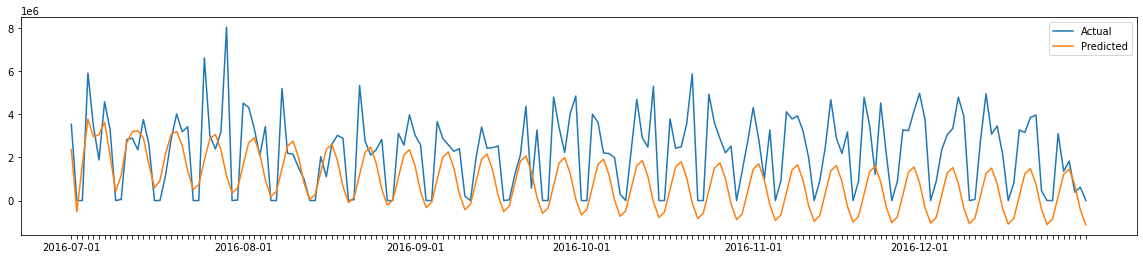

In [ ]:
# 예측 결과 시각화
temp_19 = temp_19.reset_index()

plt.figure(figsize=(20, 4))
plt.plot(temp_19[temp_19['date'] >= '2016-07-01']['date'], temp_19[temp_19['date'] >= '2016-07-01']['order_demand'],label='Actual')
plt.plot(temp_19[temp_19['date'] >= '2016-07-01']['date'], preds_19, label='Predicted')

labels = [item if item[-2:] == '01' else '' for item in sorted(day_list) if ((item[:4] == '2016') and (item[5:7] >= '07'))]
plt.xticks(temp_19[temp_19['date'] >= '2016-07-01']['date'], labels)

plt.legend()
plt.show();

위 그래프는 ARIMA를 사용하여 만든 예측 모델의 예측 결과를 시각화 한 것이다. 모델은 수요의 패턴은 유사하게 맞췄지만, 실제 수요량에서는 나타나지 않았던 우하향의 트렌드가 관찰된다.